## Mount and Fetch Data

Original tiny-imagenet-200.zip file was remodified to combine the original train & val images and split 70% - 30% into new_train and new_test

script: **python data/prepare_tiny-imagenet-200.py**

## Imports and Initialization

Import required modules

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

from data.data_engine import DataEngine
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
#from gradcam.visualize import VisualizeCam

## Model Configuration and Set Seed

View model configuration and set the seed

In [2]:
# View model config
args = ModelConfig()
args.train_data_path = '/home/rogbot/Freecodecamp/course_project/tiny-imagenet-200/new_train'
args.test_data_path = '/home/rogbot/Freecodecamp/course_project/tiny-imagenet-200/new_test'

args.print_config()
print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'test_data_path': '/home/rogbot/Freecodecamp/course_project/tiny-imagenet-200/new_test',
  'train_data_path': '/home/rogbot/Freecodecamp/course_project/tiny-imagenet-200/new_train'}

CUDA Available


## Data Loading and Visualization

Preprocess and load the tiny-imagenet-200 dataset. Visualise the dataset.

129
301


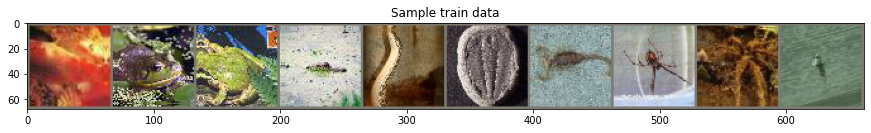

In [3]:
data = DataEngine(args)
data.show_samples()
print(len(data.test_loader))
print(len(data.train_loader))

## Model

Create model and display model summary

In [4]:
device = which_device()
model = ResNet18(num_classes=200).to(device)
show_model_summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## Training and Testing

Train the model and evaluate it

In [ ]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(data.train_loader),
                       epochs=epochs, div_factor=10, final_div_factor=10,
                       pct_start=10/epochs)

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, False)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1,
                              verbose=True, min_lr=1e-5)

misclassified_imgs, correct_imgs = [], []
epochs = 10
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1+30} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==epochs-1)
      scheduler.step(test_losses[-1])

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

## Plot Learning Rate Schedule

Plot the change in learning rate vs epochs

In [ ]:
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

## Plot Validation Loss

Plot the change in validation loss vs epochs

In [ ]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

## Plot Validation Accuracy

Plot the change in validation accracy vs epochs

In [ ]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

## Visualize GradCAM

Use GradCAM to understand where the network is looking at while prediction

In [ ]:
target_layers = ["layer1", "layer2", "layer3", "layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCAM for incorrectly classified images

Layer wise visualization of GradCAM for misclassified images

In [ ]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)